# 评分标准
- 选择模型，可用套件，也可以自己组网 （30分）

- 配置超参数并训练模型（30分）

- 测试模型效果（30分）

- 可视化模型效果（10分）

# 模型准备

## 安装环境

In [1]:
!python -m pip install paddlepaddle-gpu==2.2.0.post101 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in links: https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
     |████████████████████████████████| 431.8 MB 4.5 kB/s             ��████████▍   | 382.8 MB 44.6 MB/s eta 0:00:02
  Attempting uninstall: paddlepaddle-gpu
    Found existing installation: paddlepaddle-gpu 2.2.2.post101
    Uninstalling paddlepaddle-gpu-2.2.2.post101:
      Successfully uninstalled paddlepaddle-gpu-2.2.2.post101
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


## 安装PaddleDetection
- 下载PaddleDetection并安装至Notebook
- 安装PaddleDetection的相关依赖

In [2]:
!cd   /home/aistudio/work&&git clone https://gitee.com/PaddlePaddle/PaddleDetection.git -b develop

fatal: destination path 'PaddleDetection' already exists and is not an empty directory.


In [3]:
%cd   /home/aistudio/work/PaddleDetection/

/home/aistudio/work/PaddleDetection


In [4]:
! pip install -r requirements.txt    #安装项目必要依赖

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 2.0 MB 7.6 MB/s            
     |████████████████████████████████| 106 kB 426 kB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 1.5 MB 5.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 151 kB 4.0 MB/s            
     |████████████████████████████████| 41 kB 422 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 296 kB 2.6 MB/s            
     |████████████████████████████████| 50 kB 2.4 MB/s             
     |████████████████████████████████| 98 kB 2.3 MB/s             
     |████████████████████████████████| 99 kB 2.4 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37

## 口罩数据集处理

In [5]:
%cd /home/aistudio/data/data115986/

/home/aistudio/data/data115986


In [6]:
! unzip 有病毒时应不应该带口罩.zip

Archive:  有病毒时应不应该带口罩.zip
  inflating: maskdata/maskdata/test/with_mask/0-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/1-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/10-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/11-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/12-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/13-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/14-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/15-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/16-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/17-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/18-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/19-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/2-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/21-with-mask.jpg  
  inflating: maskdata/maskdata/test/with_mask/23-with-mask.jpg  
  

找了一圈参考决定改为voc格式方便处理，选取了新数据集

In [7]:
!unzip -oq /home/aistudio/data/data128634/Mask.zip -d /home/aistudio/DataSet

# 查看数据集的目录结构
!tree /home/aistudio/DataSet/Mask -d

/home/aistudio/DataSet/Mask
├── Annotations
└── JPEGImages

2 directories


### 显示图

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


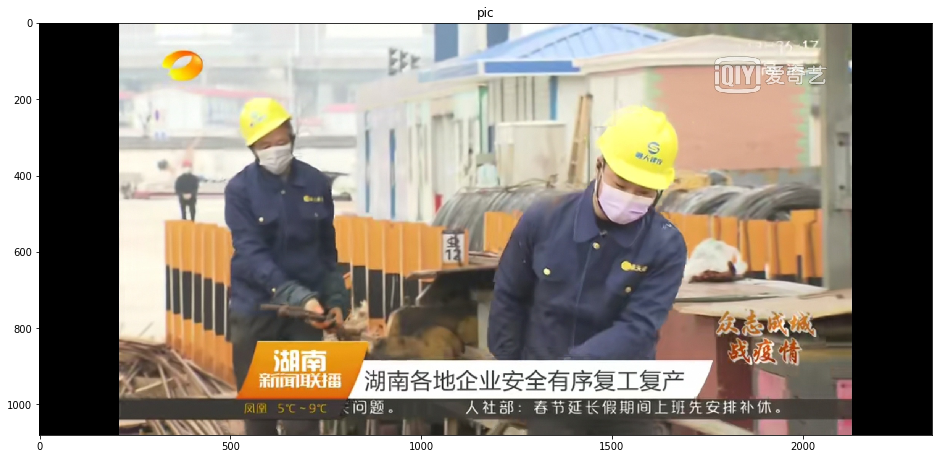

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from PIL import Image

DATA_DIR = '/home/aistudio/DataSet/Mask/JPEGImages'

file = 'train_1125.jpg'

# 读取图片
img = Image.open(os.path.join(DATA_DIR, file))
img = np.array(img)

# 画出读取的图片
plt.figure(figsize=(16, 8))
plt.title('pic')
plt.imshow(img)
plt.show()

### 划分数据集

In [9]:
import random
import os
#生成train.txt和val.txt
random.seed(2020)
xml_dir  = '/home/aistudio/DataSet/Mask/Annotations'#标签文件地址
img_dir = '/home/aistudio/DataSet/Mask/JPEGImages'#图像文件地址
path_list = list()
for img in os.listdir(img_dir):
    img_path = os.path.join(img_dir,img)
    xml_path = os.path.join(xml_dir,img.replace('jpg', 'xml'))
    path_list.append((img_path, xml_path))
random.shuffle(path_list)
ratio = 0.8
train_f = open('/home/aistudio/work/train.txt','w') #生成训练文件
val_f = open('/home/aistudio/work/val.txt' ,'w')#生成验证文件

for i ,content in enumerate(path_list):
    img, xml = content
    text = img + ' ' + xml + '\n'
    if i < len(path_list) * ratio:
        train_f.write(text)
    else:
        val_f.write(text)
train_f.close()
val_f.close()

#生成标签文档
label = ['mask','face']#设置你想检测的类别
with open('/home/aistudio/work/label_list.txt', 'w') as f:
    for text in label:
        f.write(text+'\n')

## 配置训练文件
- PP-YOLOv2：
相较20年发布的PP-YOLO，PP-YOLOv2版本在COCO 2017 test-dev上的精度提升了3.6个百分点，由45.9%提升到了49.5%；在640*640的输入尺寸下，FPS达到68.9FPS。 主要改进点：

1.Path Aggregation Network

2.Mish Activation Function

3.Larger Input Size

4.IoU Aware Branch
- 配置ppyolov2_r50vd_dcn_voc.yml文件
路径 /home/aistudio/work/PaddleDetection/configs/ppyolo/ppyolov2r50vddcnvoc.yml 其中置文件中的epoch可以根据实际情况调整，如果原文件的设置，训练时间一般较长。

另外可以选用较小的网络比如mobilenetv3-small等。 本文配置将下面的总epoch数目设置为10，训练时长大概3个小时左右。 如果想要提高检测精度可以根据实际情况增加epoch数目。

In [10]:
BASE_: [
  '../datasets/voc.yml',
  '../runtime.yml',
  './_base_/ppyolov2_r50vd_dcn.yml',
  './_base_/optimizer_365e.yml',
  './_base_/ppyolov2_reader.yml',
]

snapshot_epoch: 2    # 保存模型epoch间隔
weights: output/ppyolov2_r50vd_dcn_voc/model_final    # 模型权重路径配置

TrainReader:
  mixup_epoch: 6   #数据增强的epoch数目，根据实际情况调整
  batch_size: 12   # 批次数目也可以适当进行调整


EvalReader:
  collate_batch: false # 表示reader是否对gt进行组batch的操作，在rcnn系列算法中设置为false，得到的gt格式为list[Tensor]

epoch: 10  #总epoch数目，上面的eponch不能超过此处设置数目

LearningRate:
  base_lr: 0.00333
  schedulers:
  - !PiecewiseDecay
    gamma: 0.1
    milestones:
    - 466
    - 516
  - !LinearWarmup
    start_factor: 0.
    steps: 4000

OptimizerBuilder:
  optimizer:
    momentum: 0.9
    type: Momentum
  regularizer:
    factor: 0.0005
    type: L2

- 配置voc.yml文件
配置数据读取路径 /home/aistudio/work/PaddleDetection/configs/datasets/voc.yml 比如：

In [11]:
metric: VOC
map_type: 11point
num_classes: 2

TrainDataset:
  !VOCDataSet
    dataset_dir: /home/aistudio/work   # 数据集所在的文件夹
    anno_path: train.txt    # 训练集文件名
    label_list: label_list.txt   # 标签文件名
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

EvalDataset:
  !VOCDataSet
    dataset_dir: /home/aistudio/work
    anno_path: val.txt   # 评估数据集文件名
    label_list: label_list.txt
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

TrainDataset:
  !ImageFolder
    anno_path: /home/aistudio/work/label_list.txt

修改 work/PaddleDetection/configs/ppyolo/_base_/optimizer_365e.yml 文件里面epoch为200，学习率为0.0025

In [ ]:
epoch: 200

LearningRate:
  base_lr: 0.0025
  schedulers:
  - !PiecewiseDecay
    gamma: 0.1
    milestones:
    - 243
  - !LinearWarmup
    start_factor: 0.
    steps: 4000

OptimizerBuilder:
  clip_grad_by_norm: 35.
  optimizer:
    momentum: 0.9
    type: Momentum
  regularizer:
    factor: 0.0005
    type: L2


# 模型训练
训练模型需要说明：

- lr_schedule
- optimize
- epoch
- batch_size
- Loss function

使用GPU通过如下命令一键式启动训练(以下命令均默认在PaddleDetection根目录运行), 通过--eval参数开启训练中交替评估。
>CUDA_VISIBLE_DEVICES=0 python tools/train.py -c configs/ppyolo/ppyolo.yml --eval

可选：在训练之前使用tools/anchor_cluster.py得到适用于你的数据集的anchor，并修改configs/ppyolo/ppyolo.yml中的anchor设置

>python tools/anchor_cluster.py -c configs/ppyolo/ppyolo.yml -n 9 -s 608 -m v2 -i 1000

In [12]:
# 开始训练
%cd /home/aistudio/PaddleDetection/
!CUDA_VISIBLE_DEVICES=0
!python tools/train.py \
    -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml \
    --eval

## 模型保存

模型训练结果保存在 /home/aistudio/PaddleDetection/output/ppyolov2_r50vd_dcn_voc 目录下

下面将效果最好的模型参数另存到 /home/aistudio/work 目录下

In [13]:
!cp /home/aistudio/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdopt /home/aistudio/work
!cp /home/aistudio/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams /home/aistudio/work

# 测试模型
可视化模型效果则加分

## 模型评估

In [ ]:
%cd /home/aistudio/PaddleDetection/
!python -u tools/eval.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml -o weights=/home/aistudio/work/best_model.pdparams

## 模型预测

In [ ]:
# 将待预测图片输入到模型
%cd /home/aistudio/PaddleDetection/
!python tools/infer.py \
        -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml \
        -o weights=/home/aistudio/work/best_model.pdparams \
        --infer_img=/home/aistudio/test.jpg

模型推理结果保存在 PaddleDetection/output 路径下

In [ ]:
#将输出结果拷贝到/home/aistudio/work目录下
!cp /home/aistudio/PaddleDetection/output/test.jpg /home/aistudio/work

## 可视化模型效果

In [ ]:
# 同时展示原图像和模型预测的结果
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from PIL import Image

# 读取图片
original = Image.open('/home/aistudio/test.jpg')
original = np.array(original)
result = Image.open('/home/aistudio/work/test.jpg')
result = np.array(result)

# 画出读取的图片
plt.figure(figsize=(20, 10))
f = plt.subplot(121)
f.set_title('origin', fontsize=20)
plt.imshow(original)
f = plt.subplot(122)
f.set_title('result', fontsize=20)
plt.imshow(result)
plt.show()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))

缺少时间来不及检查运行了